# PMBus on the Ultra96

The Ultra96 has some support for monitoring power rails on the board using PMBus. PYNQ exposes these rails through the get_rails function that returns a dictionary of all of the rails available to be monitored.

In [1]:
import pynq

rails = pynq.get_rails()
rails

{'1V2': Rail {name=1V2, voltage=Sensor {name=1V2_voltage, value=1.203V}, current=Sensor {name=1V2_current, value=0.031A}, power=Sensor {name=1V2_power, value=0.03125W}},
 '3V3': Rail {name=3V3, voltage=Sensor {name=3V3_voltage, value=3.304V}, current=Sensor {name=3V3_current, value=0.171A}, power=Sensor {name=3V3_power, value=0.5625W}},
 '3V3_D': Rail {name=3V3_D, voltage=Sensor {name=3V3_D_voltage, value=3.343V}, current=Sensor {name=3V3_D_current, value=0.0A}, power=Sensor {name=3V3_D_power, value=0.0W}},
 'AUX': Rail {name=AUX, voltage=Sensor {name=AUX_voltage, value=1.8V}, current=Sensor {name=AUX_current, value=0.031A}, power=Sensor {name=AUX_power, value=0.03125W}},
 'INT': Rail {name=INT, voltage=Sensor {name=INT_voltage, value=0.847V}, current=Sensor {name=INT_current, value=0.312A}, power=Sensor {name=INT_power, value=0.25W}},
 'PSAUX': Rail {name=PSAUX, voltage=Sensor {name=PSAUX_voltage, value=1.8V}, current=Sensor {name=PSAUX_current, value=0.171A}, power=Sensor {name=PSAUX

Depending on whether you are using Ultra96 v1 or v2, you may see a different set of rails.

As can be seen, the keys of the dictionary are the names of the voltage rails while the values are `Rail` objects which contain three sensors for the voltage, current and power.

To see how power changes under CPU load we can use the `DataRecorder` class. 
For this example we are going to look at a specific power rail (depending on v1 or v2)
as we load one of the CPU cores in Python.

In [7]:
if 'VSYS' in rails.keys():
    print("Recording Ultra96 v1 power...")
    rail_name = 'VSYS'
elif 'PSINT_FP' in rails.keys():
    print("Recording Ultra96 v2 power...")
    rail_name = 'PSINT_FP'
else:
    raise RuntimeError("Cannot determine Ultra96 board version.")
    
rail_name = 'PSPLL'
recorder = pynq.DataRecorder(rails[rail_name].power)

Recording Ultra96 v2 power...


We can now use the recorder to monitor the applied sensor. For this example we'll sample the power every half second while sleeping and performing a dummy loop.

In [12]:
import time
with recorder.record(0.5):
    time.sleep(5)
    for _ in range(10000000):
        pass
    time.sleep(5)

The `DataRecorder` exposes the sensor data as a pandas dataframe.

In [9]:
recorder.frame

,Mark,PSPLL_power
2021-02-25 17:25:54.614840,0.0,0.03125
2021-02-25 17:25:55.128003,0.0,0.03125
2021-02-25 17:25:55.708175,0.0,0.03125
2021-02-25 17:25:56.220698,0.0,0.03125
2021-02-25 17:25:56.800820,0.0,0.03125
2021-02-25 17:25:57.313227,0.0,0.03125
2021-02-25 17:25:57.893554,0.0,0.03125
2021-02-25 17:25:58.406051,0.0,0.03125
2021-02-25 17:25:58.991587,0.0,0.03125
2021-02-25 17:25:59.504155,0.0,0.03125


Or by plotting the results using matplotlib.

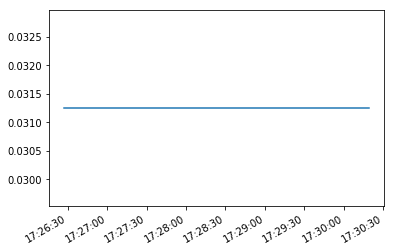

In [13]:
%matplotlib inline
recorder.frame['{}_power'.format(rail_name)].plot()

We can get more information by using the `mark` function which will increment the invocation number without having to stop and start the recorder.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f970d10b8>,
      dtype=object)

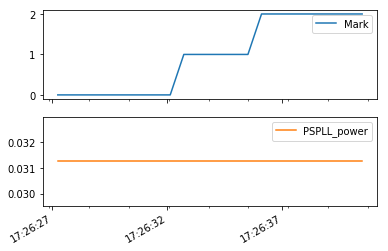

In [11]:
recorder.reset()
with recorder.record(0.5):
    time.sleep(5)
    recorder.mark()
    for _ in range(10000000):
        pass
    recorder.mark()
    time.sleep(5)
    
recorder.frame.plot(subplots=True)

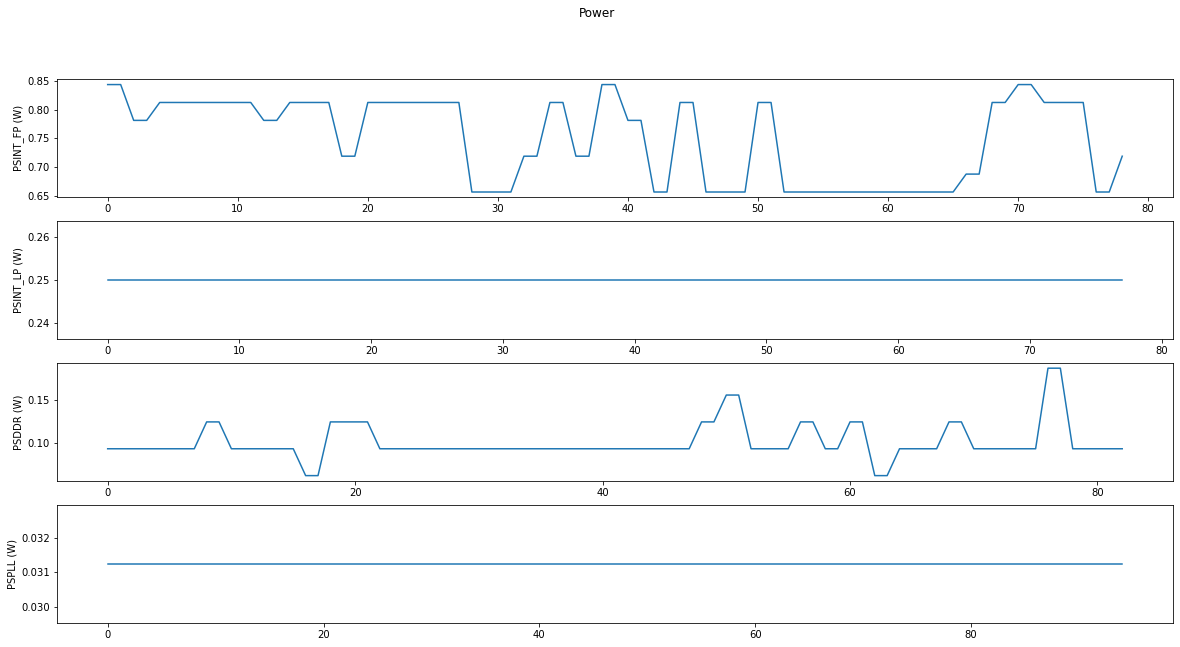

In [21]:
import pandas as pd

a = pd.read_csv('PSINT_FP.csv')
b = pd.read_csv('PSINT_LP.csv')
c = pd.read_csv('PSDDR.csv')
d = pd.read_csv('PSPLL.csv')

from matplotlib import pyplot as plt

fig, axs = plt.subplots(4,figsize=(20, 10))
fig.suptitle('Power')
axs[0].set_ylabel('PSINT_FP (W)')
axs[1].set_ylabel('PSINT_LP (W)')
axs[2].set_ylabel('PSDDR (W)')
axs[3].set_ylabel('PSPLL (W)')
axs[0].plot(a['{}_power'.format('PSINT_FP')])
axs[1].plot(b['{}_power'.format('PSINT_LP')])
axs[2].plot(c['{}_power'.format('PSDDR')])
axs[3].plot(d['{}_power'.format('PSPLL')])

^C


This clearly shows the power spike when the for loop starts running.